# Meteorological conditions during SSW events

In [1]:
import xarray as xr
import xarray.ufuncs as xrf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob

## Definition of functions

In [67]:
def read_group(gruppe,loc):
    station = loc#ersten Buchstaben bitte bitte groß schreiben
    
    if loc=='Rio':
        timestart = '2008-02-01'
        timeend = '2019-12-31'
    elif loc == 'Col':
        timestart =  '2004-08-01'
        timeend =  '2019-03-06'
    elif loc=='CMA':
        timestart = '2002-01-01'
        timeend = '2018-12-31'
    elif loc=='Dav':
        timestart = '2005-01-01'
        timeend ='2019-12-31'
    elif loc=='Kir':
        timestart = '1999-08-01'
        timeend ='2019-12-31'
    
    infiles = f'{root_path}{station}/Meteor_radar_{station}_GW_*.h5'
    if gruppe == 'tides':
        ds = xr.open_mfdataset(infiles, concat_dim = 'phony_dim_4', group = gruppe, combine='nested', parallel = True)
        ds = ds.rename({'phony_dim_4': 'time', 'phony_dim_5': 'alt'})
    else:
        ds = xr.open_mfdataset(infiles, concat_dim = 'phony_dim_6', group = gruppe, combine='nested', parallel = True)
        ds = ds.rename({'phony_dim_6': 'time', 'phony_dim_7': 'alt'})
    ds['alt'] = alt
    ds['alt'].attrs['units'] = 'km'
    # change time range according to meteor radar station
    ds['time'] = pd.date_range(start = timestart, end = timeend, periods = ds.time.shape[0]) 
    return ds

In [3]:
def read_var(gruppe, var):
        varout = gruppe[var]
        return varout

In [4]:
def hwind(u,v):
    return np.sqrt(u**2+v**2)

In [5]:
def time_mean(step,var):
    return var.resample(time='1'+step).mean('time') #Immer nur D oder M oder H oder Y eintragen! Mit Anführungszeichen!

In [6]:
def anomalie(step,var):
    string = "time."+step   
    climatology = var.groupby(string).mean("time")
    anomalies = var.groupby(string) - climatology
    
    return anomalies

In [7]:
def grav_waves(wind_component,loc): # Beides muss schon als String reingegeben werden! 
    ds = read_group('wind',loc)
    gw = read_var(ds,wind_component) - read_var(ds,wind_component+'_fil')
    return gw

In [8]:
def kin_energy_grav_waves(loc):
    kin_energy = 0.5*((grav_waves('u',loc))**2 + (grav_waves('v',loc))**2)
    return kin_energy

#### Superposed Epoch Analysis

In [9]:
def sea(days_period,station,var):
    df_dates = pd.read_csv('ssw_dates_displ_'+station+'.csv') # you can load SSWs from a csv file like attached
    dates = df_dates.set_index('BeginDate')

    xa_ls = []
    max_lag = days_period
    for il, days in enumerate(range(-max_lag,max_lag+1)):  
        sel_dates = pd.to_datetime(dates.index) + pd.Timedelta(str(days)+' days')
        mask = np.in1d(var.time.dt.floor('1D'),sel_dates)
        comp_m = var.sel(time = mask).mean('time')
        xa_ls.append(comp_m)
   
    xa_comp = xr.concat(xa_ls, dim = 'days')
    xa_comp['days'] = range(-max_lag, max_lag+1)

    # print(xa_comp)
    return xa_comp

## SSW-Events

In [10]:
ssw_events = ['2008-02-21','2009-01-23','2010-01-26','2010-02-09','2010-03-24','2011-02-01','2011-03-25','2012-01-17','2013-01-06','2013-01-17','2014-03-31','2015-01-05','2016-03-16','2018-02-12']

In [11]:
alt = [70, 72, 74, 76, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, \
       106, 108, 110, 112, 114, 116, 118, 120]
root_path = '/home/gemeinsam_tmp/UA_students/data/'
#xr.open_dataset( '/home/gemeinsam_tmp/UA_students/data/Kir/Meteor_radar_Kir_GW_201912.h5', group='info')['day']

## Measurements

### Wind

#### Collm

/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 31 times more chunks
  return self.array[key]
/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


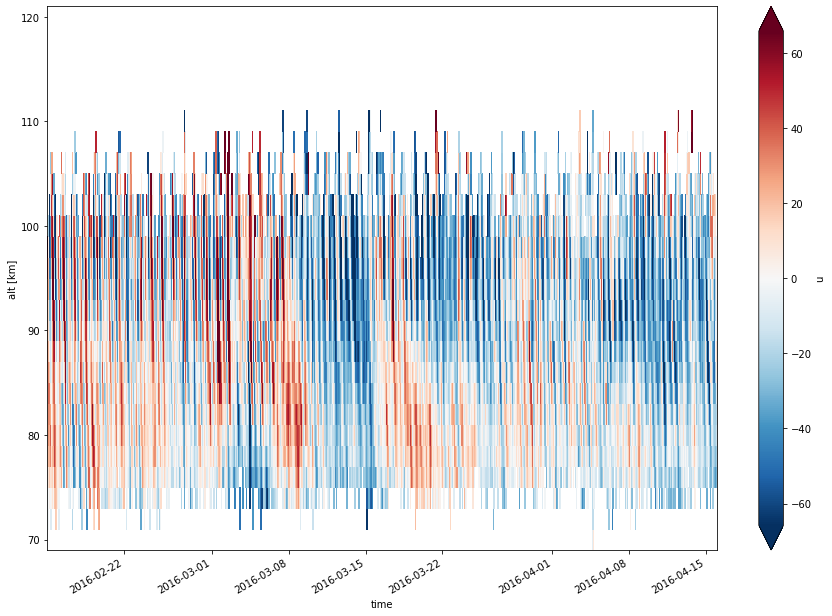

In [12]:
ds_col = read_group('wind','Col')
u_col = read_var(ds_col,'u')
v_col = read_var(ds_col,'v')

u_col_anomalie = anomalie('hour',u_col)
# u_col_anomalie.plot(x='time',robust=True)

v_col_anomalie = anomalie('day',v_col)

sea_u_col = sea(30,'Col',u_col)
sea_u_col_anomalie = sea(30,'Col',u_col_anomalie)

sea_v_col = sea(30,'Col',v_col)
sea_v_col_anomalie = sea(30,'Col',v_col_anomalie)

u_col_anomalie.sel(time=slice('2016-02-15', '2016-04-15')).plot(x='time',size=10,robust=True)

##### Climatology of u-component

/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


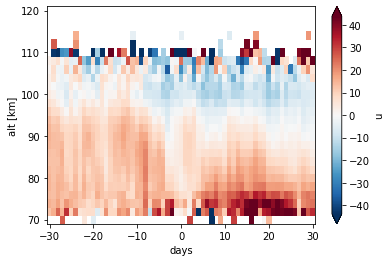

In [13]:
sea_u_col.plot(x='days',robust=True)

##### Anomalies of u-component

/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


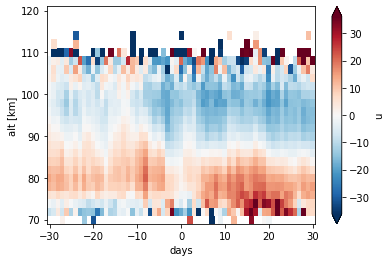

In [14]:
sea_u_col_anomalie.plot(x='days',robust=True)

##### Climatology of v-component

/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


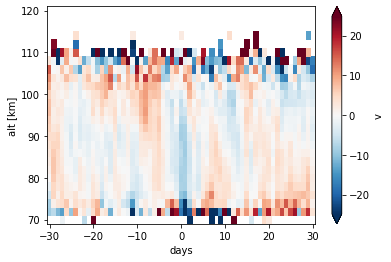

In [15]:
sea_v_col.plot(x='days',robust=True)

##### Anomalies of v-component

/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


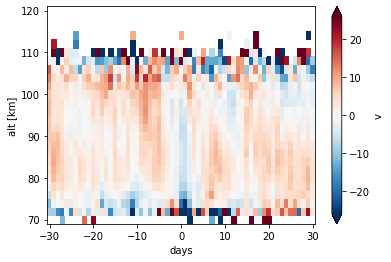

In [16]:
sea_v_col_anomalie.plot(x='days',robust=True)

#### CMA Canadian Meteor Orbit Radar (CMOR) (London, Ontario - Canada)

In [17]:
ds_cma = read_group('wind','CMA')
u_cma = read_var(ds_cma,'u')  
v_cma = read_var(ds_cma,'v')

u_cma_anomalie = anomalie('day',u_cma)
# u_cma_anomalie.plot(x='time',robust=True)

v_cma_anomalie = anomalie('day',v_cma)

sea_u_cma = sea(30,'CMA',u_cma)
sea_u_cma_anomalie = sea(30,'CMA',u_cma_anomalie)

sea_v_cma = sea(30,'CMA',v_cma)
sea_v_cma_anomalie = sea(30,'CMA',v_cma_anomalie)

##### Climatology of u-component

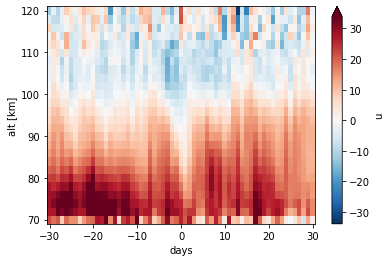

In [18]:
sea_u_cma.plot(x='days',robust=True)

##### Anomalies of u-component

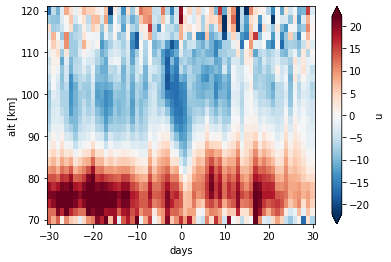

In [19]:
sea_u_cma_anomalie.plot(x='days',robust=True)

##### Climatology of v-component

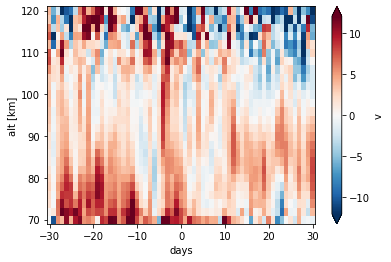

In [20]:
sea_v_cma.plot(x='days',robust=True)

##### Anomalies of v-component

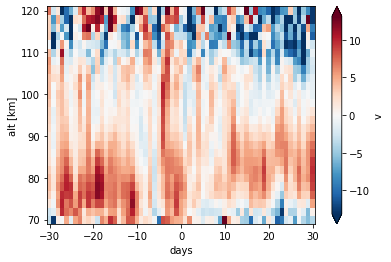

In [21]:
sea_v_cma_anomalie.plot(x='days',robust=True)

#### Davis (Antarctic)

In [22]:
ds_dav = read_group('wind','Dav')
u_dav = read_var(ds_dav,'u')  
v_dav = read_var(ds_dav,'v')

u_dav_anomalie = anomalie('day',u_dav)
# u_rio_anomalie.plot(x='time',robust=True)

v_dav_anomalie = anomalie('day',v_dav)

sea_u_dav = sea(30,'Dav',u_dav)
sea_u_dav_anomalie = sea(30,'Dav',u_dav_anomalie)

sea_v_dav = sea(30,'Dav',v_dav)
sea_v_dav_anomalie = sea(30,'Dav',v_dav_anomalie)

##### Climatology of u-component

/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


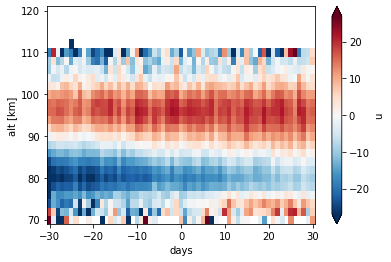

In [23]:
sea_u_dav.plot(x='days',robust=True)

##### Anomalies of u-component

/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


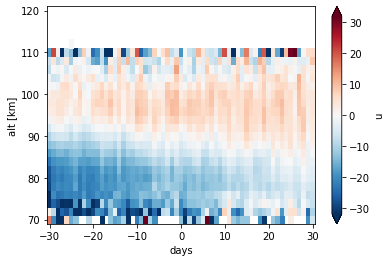

In [24]:
sea_u_dav_anomalie.plot(x='days',robust=True)

##### Climatology of v-component

/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


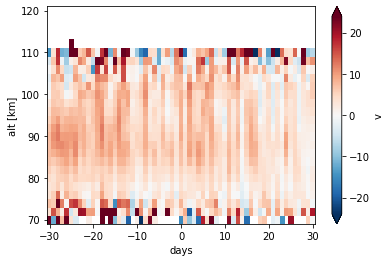

In [25]:
sea_v_dav.plot(x='days',robust=True)

##### Anomalies of v-component

/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


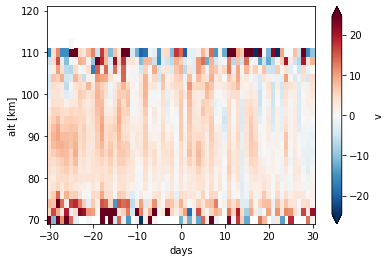

In [26]:
sea_v_dav_anomalie.plot(x='days',robust=True)

#### Rio Grande

In [27]:
ds_rio = read_group('wind','Rio')
u_rio = read_var(ds_rio,'u')  
v_rio = read_var(ds_rio,'v')

u_rio_anomalie = anomalie('day',u_rio)
# u_rio_anomalie.plot(x='time',robust=True)

v_rio_anomalie = anomalie('day',v_rio)

sea_u_rio = sea(30,'Rio',u_rio)
sea_u_rio_anomalie = sea(30,'Rio',u_rio_anomalie)

sea_v_rio = sea(30,'Rio',v_rio)
sea_v_rio_anomalie = sea(30,'Rio',v_rio_anomalie)

##### Climatology of u-component

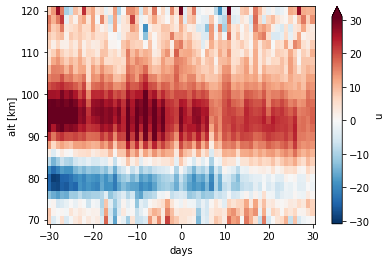

In [28]:
sea_u_rio.plot(x='days',robust=True)

##### Anomalies of u-component

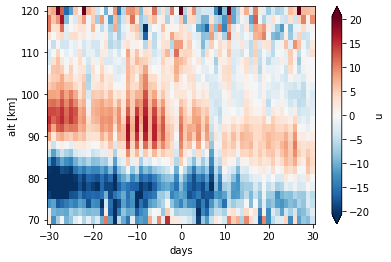

In [29]:
sea_u_rio_anomalie.plot(x='days',robust=True)

##### Climatology of v-component

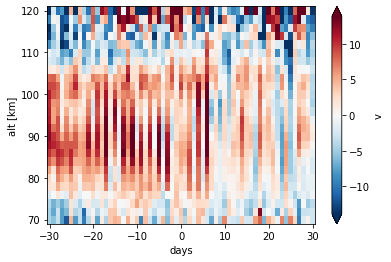

In [30]:
sea_v_rio.plot(x='days',robust=True)

##### Anomalies of v-component

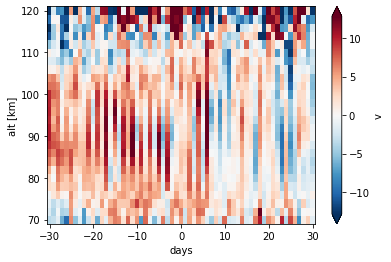

In [31]:
sea_v_rio_anomalie.plot(x='days',robust=True)

#### Kiruna, Norrbotten (Sweden)

In [32]:
ds_kir = read_group('wind','Kir')
u_kir = read_var(ds_kir,'u')  
v_kir = read_var(ds_kir,'v')

u_kir_anomalie = anomalie('day',u_kir)
# u_rio_anomalie.plot(x='time',robust=True)

v_kir_anomalie = anomalie('day',v_kir)

sea_u_kir = sea(30,'Kir',u_kir)
sea_u_kir_anomalie = sea(30,'Kir',u_kir_anomalie)

sea_v_kir = sea(30,'Kir',v_kir)
sea_v_kir_anomalie = sea(30,'Kir',v_kir_anomalie)

##### Climatology of u-component

/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


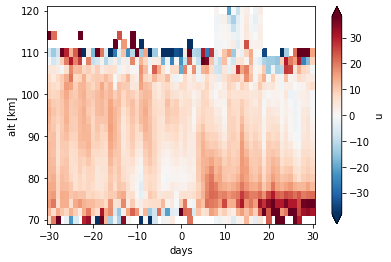

In [33]:
sea_u_kir.plot(x='days',robust=True)

##### Anomalies of u-component

/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


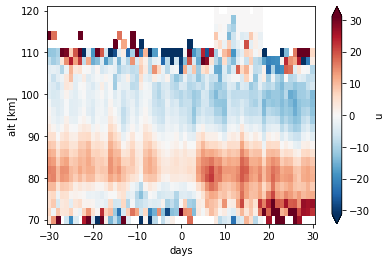

In [34]:
sea_u_kir_anomalie.plot(x='days',robust=True)

##### Climatology of v-component

/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


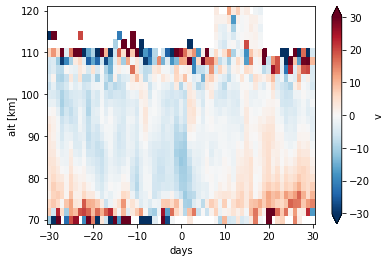

In [35]:
sea_v_kir.plot(x='days',robust=True)

##### Anomalies of v-component

/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


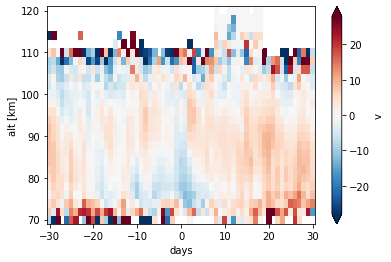

In [36]:
sea_v_kir_anomalie.plot(x='days',robust=True)

### Gravity waves

#### Collm

In [37]:
# gw_u_col = grav_waves('u','Col')
# gw_v_col = grav_waves('v','Col')
# gw_total_energy_neu_col = 0.5*(gw_u_col**2 + gw_v_col**2)
gw_total_energy_col = kin_energy_grav_waves('Col')

# sea_gw_u_col = sea(60,'Col',gw_u_col)
# sea_gw_v_col = sea(60,'Col',gw_v_col)

# sea_gw_total_energy_neu_col = sea(60,'Col',gw_total_energy_neu_col)
sea_gw_total_energy_col = sea(90,'Col',gw_total_energy_col)


gw_total_energy_col_anomalie = anomalie('day',gw_total_energy_col)

sea_gw_total_energy_col_anomalie = sea(90,'Col',gw_total_energy_col_anomalie)

##### Total kinetic energy of gravity waves

/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


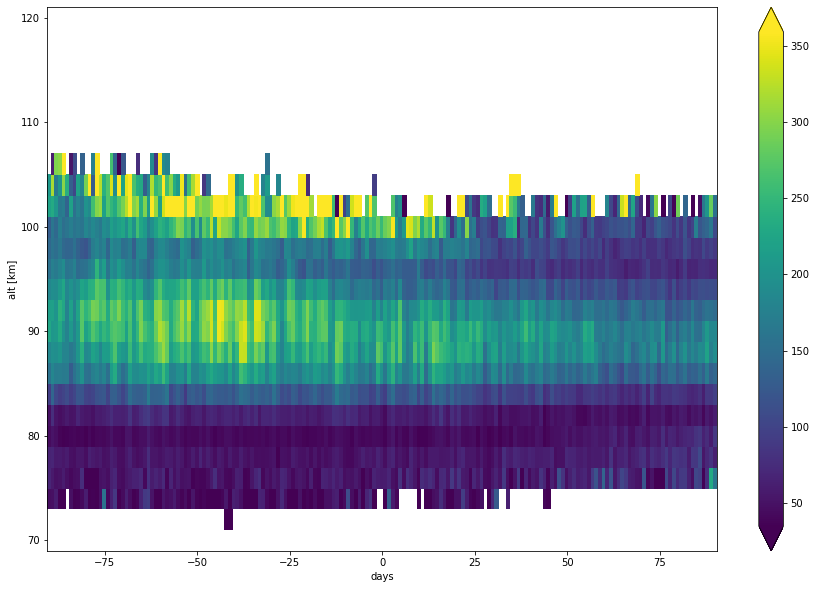

In [38]:
sea_gw_total_energy_col.plot(x='days',size=10,robust=True)

Observation: After the onset of the SSW the kinetic enrgy of the gravity waves shows a slight decrease. This would mean that around and after SSW's less or at least weaker gravity waves are present in the Mesosphere. Especially the zonal component shows this decrease as well.

Notiz: Vielleicht aber nur die Energie zeigen und nicht noch die einzelnen Komponenten - das wird sonst zu viel...

##### Anomalies of the total kinetic energy of gravity waves

/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


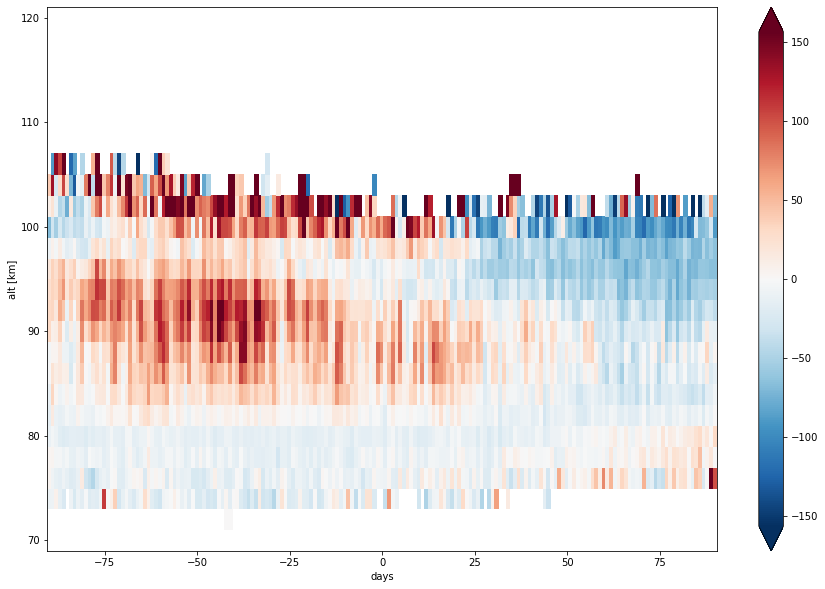

In [39]:
sea_gw_total_energy_col_anomalie.plot(x='days',size=10,robust=True)

#### Rio Grande

In [40]:
gw_total_energy_rio = kin_energy_grav_waves('Rio')

sea_gw_total_energy_rio = sea(60,'Rio',gw_total_energy_rio)


gw_total_energy_rio_anomalie = anomalie('day',gw_total_energy_rio)

sea_gw_total_energy_rio_anomalie = sea(60,'Rio',gw_total_energy_rio_anomalie)

##### Total kinetic energy of gravity waves

/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


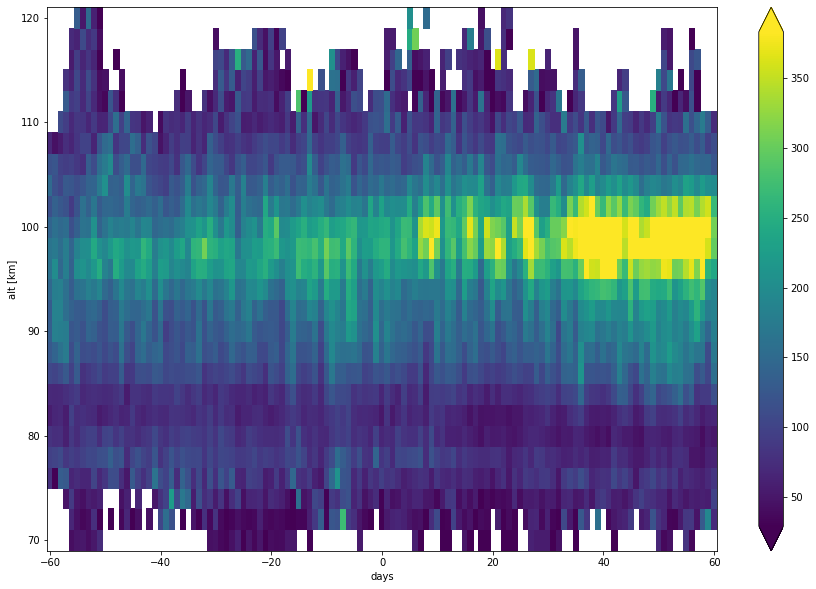

In [41]:
sea_gw_total_energy_rio.plot(x='days',size=10,robust=True)

##### Anomalies of the total kinetic energy of gravity waves

/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


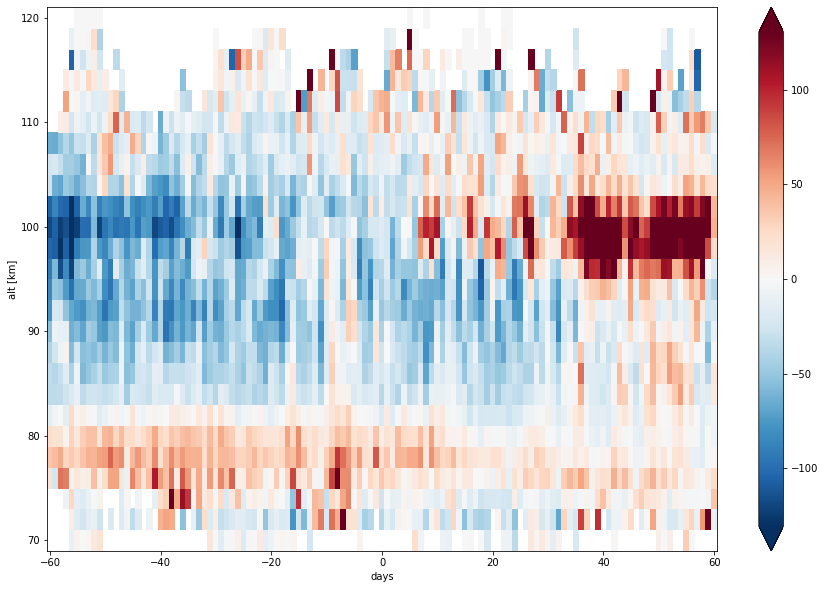

In [42]:
sea_gw_total_energy_rio_anomalie.plot(x='days',size=10,robust=True)

#### CMA Canadian Meteor Orbit Radar (CMOR) (London, Ontario - Canada)

In [43]:
gw_total_energy_cma = kin_energy_grav_waves('CMA')

sea_gw_total_energy_cma = sea(60,'CMA',gw_total_energy_cma)


gw_total_energy_cma_anomalie = anomalie('day',gw_total_energy_cma)

sea_gw_total_energy_cma_anomalie = sea(60,'CMA',gw_total_energy_cma_anomalie)

##### Total kinetic energy of gravity waves

/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


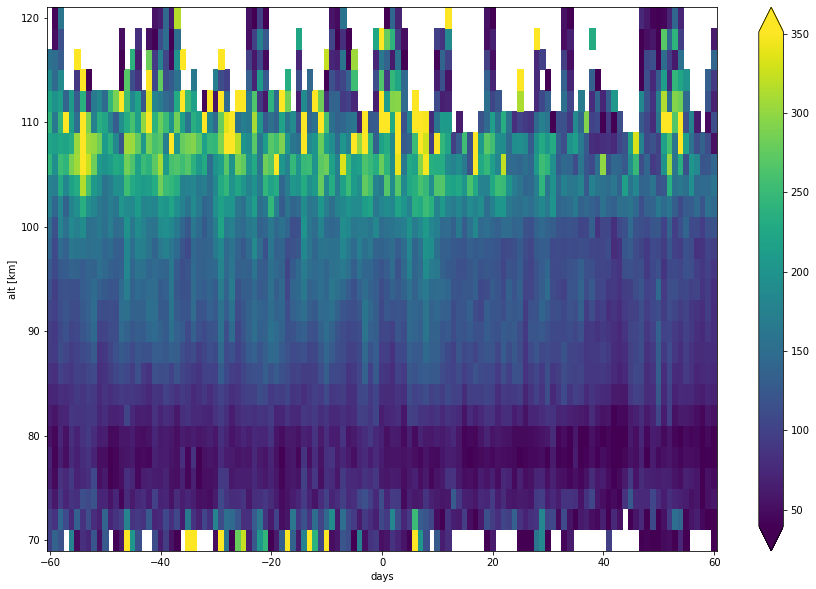

In [44]:
sea_gw_total_energy_cma.plot(x='days',size=10,robust=True)

##### Anomalies of the total kinetic energy of gravity waves

/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


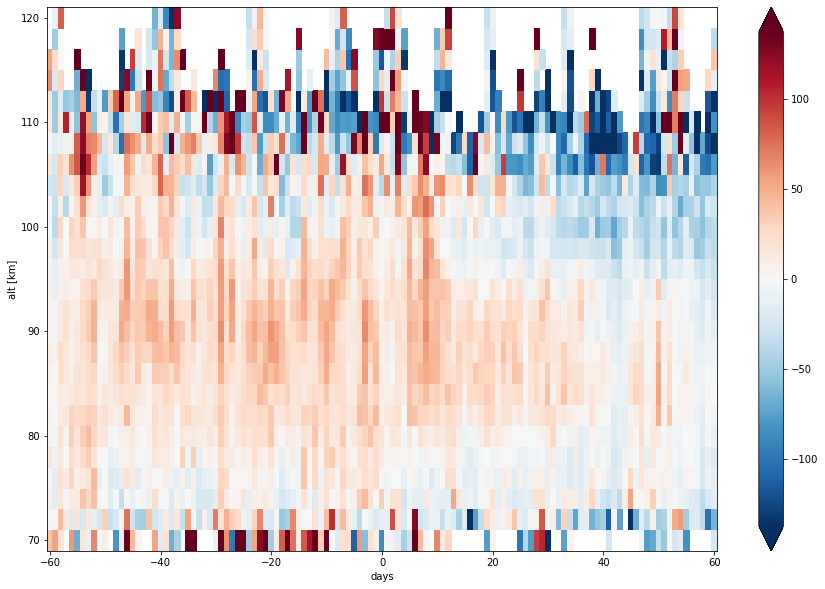

In [45]:
sea_gw_total_energy_cma_anomalie.plot(x='days',size=10,robust=True)

#### Davis (Antarctic)

In [46]:
gw_total_energy_dav = kin_energy_grav_waves('Dav')

sea_gw_total_energy_dav = sea(60,'Dav',gw_total_energy_dav)


gw_total_energy_dav_anomalie = anomalie('day',gw_total_energy_dav)

sea_gw_total_energy_dav_anomalie = sea(60,'Rio',gw_total_energy_dav_anomalie)

##### Total kinetic energy of gravity waves

/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


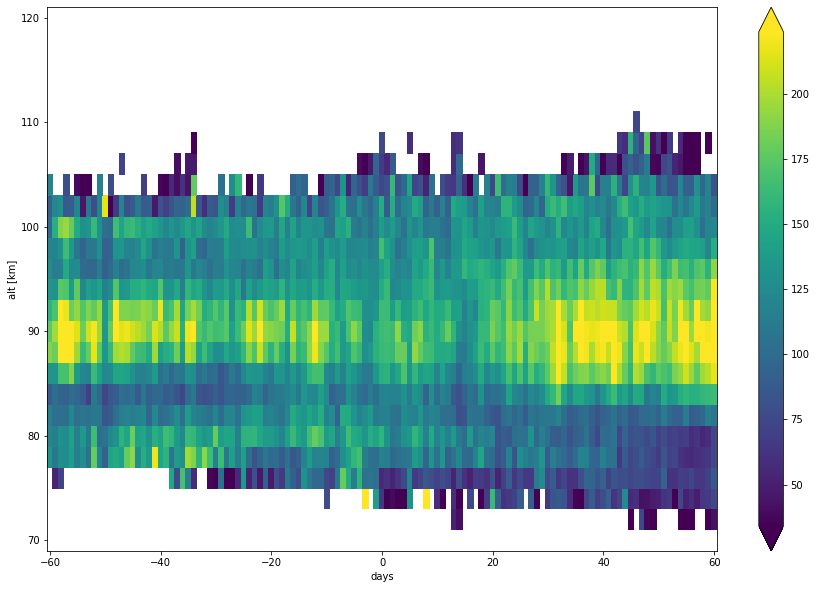

In [47]:
sea_gw_total_energy_dav.plot(x='days',size=10,robust=True)

##### Anomalies of the total kinetic energy of gravity waves

/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


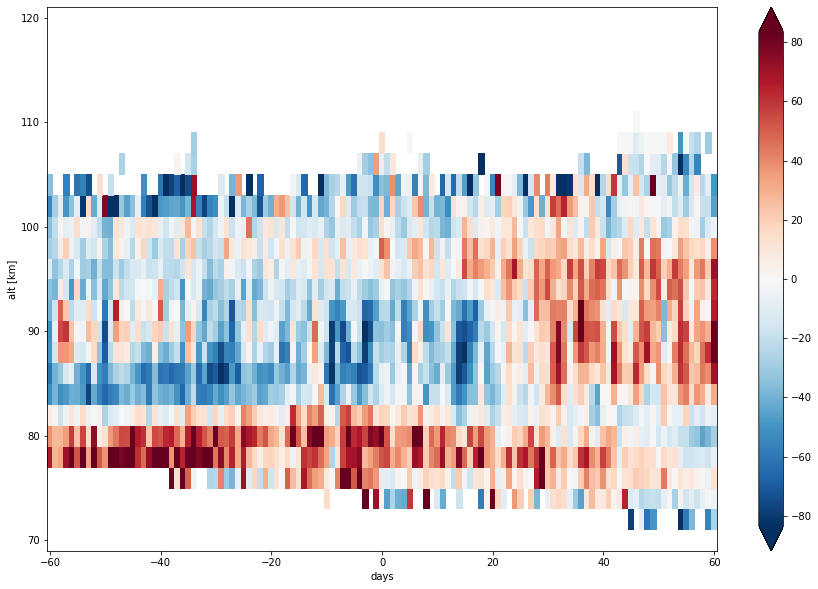

In [48]:
sea_gw_total_energy_dav_anomalie.plot(x='days',size=10,robust=True)

#### Kiruna, Norrbotten (Sweden)

In [49]:
gw_total_energy_kir = kin_energy_grav_waves('Kir')

sea_gw_total_energy_kir = sea(60,'Kir',gw_total_energy_kir)


gw_total_energy_kir_anomalie = anomalie('day',gw_total_energy_kir)

sea_gw_total_energy_kir_anomalie = sea(60,'Kir',gw_total_energy_kir_anomalie)

##### Total kinetic energy of gravity waves

/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


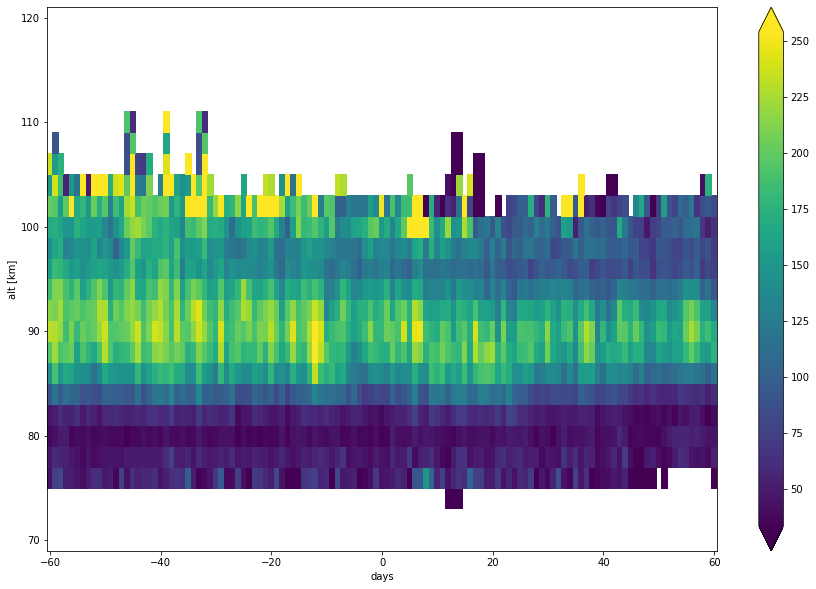

In [50]:
sea_gw_total_energy_kir.plot(x='days',size=10,robust=True)

##### Anomalies of the total kinetic energy of gravity waves

/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


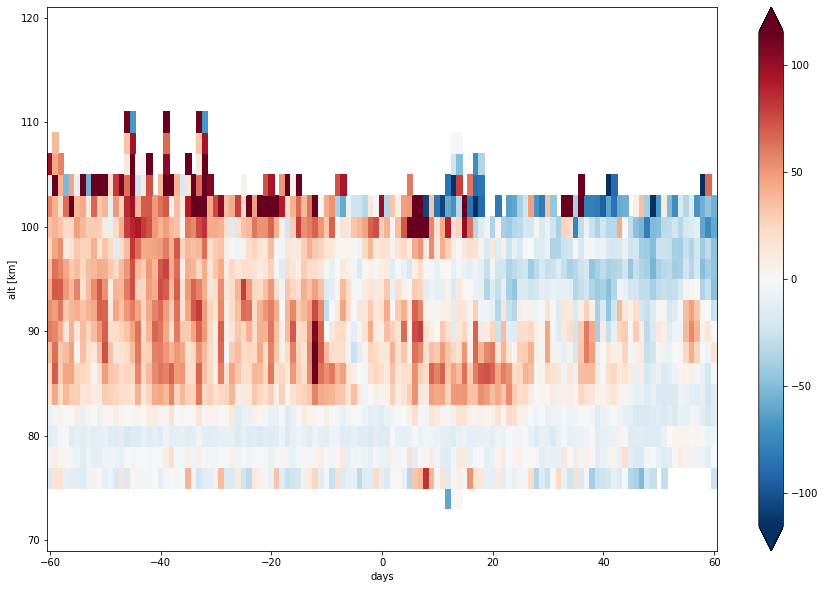

In [51]:
sea_gw_total_energy_kir_anomalie.plot(x='days',size=10,robust=True)

#### Interpretation

Concerning the gravity waves we see a different behaviour for both hemispheres. The meteor radars on the northern hemisphere show an increased level of gravity wave kinetic energy before and around - maybe short time after, too - the onset of the SSW's. Later the activity of gravity waves reduces to the normal climatological amount.

On the southern hemisphere this is vice-versa. Before the SSW-onset gravity waves are at a low level. Approximately 2 to 3 weeks afterwards the kinetic energy is significantly increased compared to the climatological mean.

--> Reason?

### Tides

#### Collm

In [68]:
tides_col = read_group('tides','Col')

diurnal_u_col = read_var(tides_col,'A24u')
semidiurnal_u_col = read_var(tides_col,'A12u')
terdiurnal_u_col = read_var(tides_col,'A8u')

In [69]:
sea_diurnal_u_col = sea(30,'Col',diurnal_u_col)
sea_semidiurnal_u_col = sea(30,'Col',semidiurnal_u_col)
sea_terdiurnal_u_col = sea(30,'Col',terdiurnal_u_col)

/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


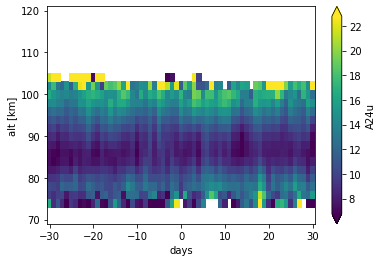

In [70]:
sea_diurnal_u_col.plot(x='days',robust=True)

/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


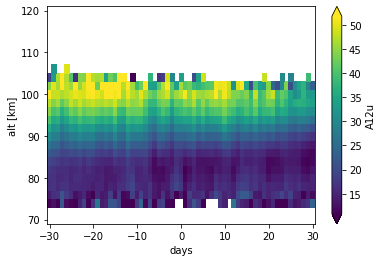

In [71]:
sea_semidiurnal_u_col.plot(x='days',robust=True)

/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


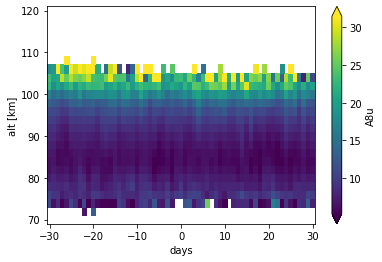

In [72]:
sea_terdiurnal_u_col.plot(x='days',robust=True)